In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 544kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=ade03efb44b1b61ad4e532179f81f6541f8415868ba2f65159e4cc820d551f59
  Stored in directory: /tmp/pip-ephem-wheel-cache-n4fnww2o/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [0]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [0]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 275kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 80.0kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 77.1kB/s]


In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [9]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [0]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [11]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, n_layers)

    def forward(self, src): #src = [batch size, seq len]
        # src = src.transpose(1,0) #src = [seq len, batch size]
        embedded = self.embedding(src) # embedded = [seq len , batch size, emb dim]
        output,hidden = self.gru(embedded) #out = [seq len, batch size, hid dim] // hid = [n layer * n directions, batch size, hid dim]
        
        output = output.transpose(1,0) #out = [batch size, seq len, hid dim]
        hidden = hidden.transpose(1,0) #hid = [batch size, n layer * n directions, hid dim]
        
        return output, hidden


class BahdanauAttention(nn.Module):

    def __init__(self, units, hid_dim):
        super(BahdanauAttention, self).__init__()
        self.sofmax = nn.Softmax()
        self.W1 = nn.Linear(hid_dim, units, bias=False) 
        self.W2 = nn.Linear(hid_dim, units, bias=False) 
        self.V = nn.Linear(units, 1, bias=False)

    def forward(self, query, values):
        
        score = self.V(torch.tanh(self.W1(values) + self.W2(query)))

        attention_weights = F.softmax(score, dim=1) # attention_weights = [batch_size, max_length, 1]

        context_vector = attention_weights * values
                       
        total_context = context_vector.sum(1)  # context_vector = [batch_size, hidden_size]
        
        return total_context, attention_weights


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, n_layers=1):
        super(Decoder, self).__init__()
        self.output_dim = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim+dec_units, dec_units, n_layers)
        self.fc = nn.Linear(dec_units, vocab_size)

        self.attention = BahdanauAttention(dec_units, dec_units)

    def forward(self, x, hidden, enc_output):
       
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x) # x = [batch_size, 1, embedding_dim]
        x= torch.cat((x, context_vector.unsqueeze(1)), axis=-1) # x = [batch_size, 1, embedding_dim + hidden_size]
        
        x1=x.transpose(1,0)

        output, state = self.gru(x1)

        # output shape == (batch_size * 1, hidden_size)
        output = output.reshape(-1, output.shape[2])
        state = state.reshape(-1, state.shape[2])

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return  x, state, attention_weights

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        inputs = trg[0,:]
        
        for t in range(1, trg_len):
            
            inputs=inputs.unsqueeze(1)
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(inputs, hidden, encoder_outputs)
            hidden = hidden.unsqueeze(1)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            inputs = trg[t] if teacher_force else top1

        return outputs

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, BATCH_SIZE)

model = Seq2Seq(encoder, decoder, device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (gru): GRU(256, 512)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (gru): GRU(768, 512)
    (fc): Linear(in_features=512, out_features=5893, bias=True)
    (attention): BahdanauAttention(
      (sofmax): Softmax(dim=None)
      (W1): Linear(in_features=512, out_features=512, bias=False)
      (W2): Linear(in_features=512, out_features=512, bias=False)
      (V): Linear(in_features=512, out_features=1, bias=False)
    )
  )
)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,219,269 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())


In [0]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/seq2seq/torch-model_temp.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 45s
	Train Loss: 2.118 | Train PPL:   8.313
	 Val. Loss: 3.388 |  Val. PPL:  29.593
Epoch: 02 | Time: 0m 45s
	Train Loss: 2.005 | Train PPL:   7.425
	 Val. Loss: 3.441 |  Val. PPL:  31.219
Epoch: 03 | Time: 0m 45s
	Train Loss: 1.918 | Train PPL:   6.809
	 Val. Loss: 3.437 |  Val. PPL:  31.092
Epoch: 04 | Time: 0m 45s
	Train Loss: 1.826 | Train PPL:   6.207
	 Val. Loss: 3.420 |  Val. PPL:  30.554


KeyboardInterrupt: ignored

In [0]:
# model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/seq2seq/torch-model_temp.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.411 | Test PPL:  30.294 |


In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)


    # mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        trg_tensor = trg_tensor.unsqueeze(1)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
            attention=attention.permute(0,2,1)


        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]


def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [0]:
example_idx = 1000

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'schneidet', 'tomaten', 'der', ',', 'hemd', 'weißen', 'einem', 'in', 'mann', 'junger', 'ein']
trg = ['a', 'young', 'man', 'in', 'a', 'white', 'shirt', 'cutting', 'tomatoes', '.']


In [0]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'young', 'man', 'in', 'a', 'white', 'shirt', 'shirt', 'is', 'cutting', 'something', '.', '<eos>']


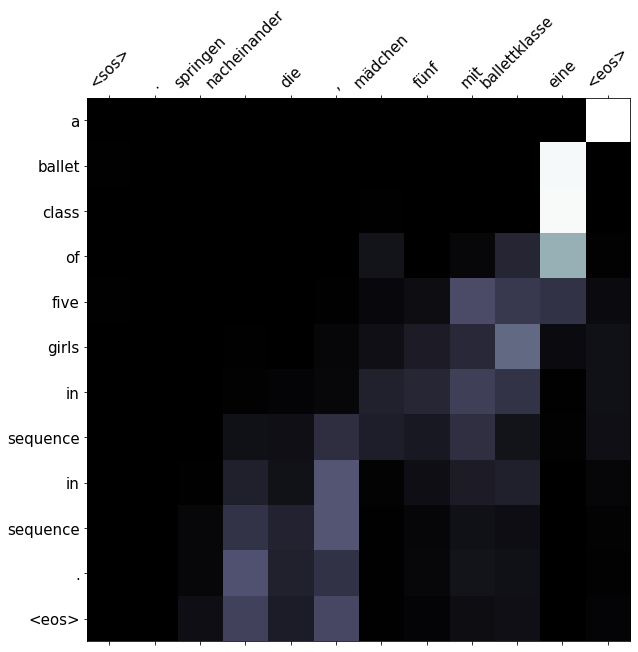

In [0]:
display_attention(src, translation, attention)
